# Simple GAN

In this notebook, I implemented a really simple GAN, with two dense layers in the generator and one convolutionnal layer for the discriminator. 

Since, it does not demand a lot of computational power, I could increase the image resolution to 64x64.

In [17]:
%load_ext autoreload
%autoreload 2

import sys

import numpy as np

from IPython.core.debugger import Tracer

from keras.datasets import mnist

from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Conv2D
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam, RMSprop, SGD

import matplotlib.pyplot as plt
import random
import os
import cv2
from keras import backend as K 

import random

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the dataset

In [18]:
resolution_max = 64
latent_dim =512

In [19]:
DATA_FOLDER = "./img_align_celeba/"

In [20]:
selection =random.sample(os.listdir(DATA_FOLDER), 10000)
X_train = [cv2.resize(cv2.imread(DATA_FOLDER+file),(resolution_max,resolution_max), interpolation = cv2.INTER_CUBIC) for file in selection]
X_train = np.array(X_train)
X_train = X_train / 127.5 - 1. 
X_train[0].shape

(64, 64, 3)

## Show some example from the dataset

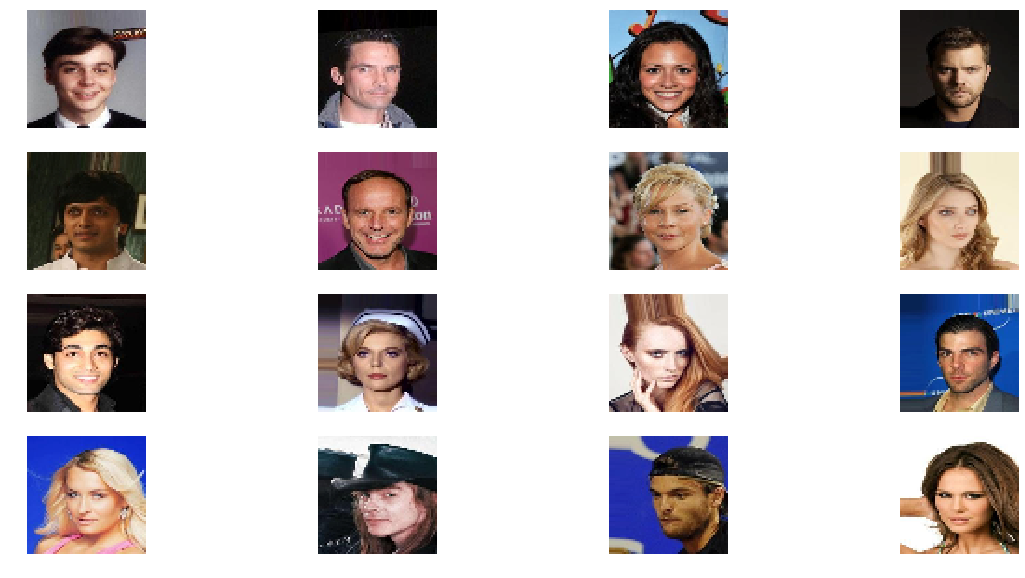

In [21]:
resize_factor = 0.5
r =4
c =4
fig, axs = plt.subplots(r, c, figsize=(20, 10))    
cnt = 0

for i in range(r):
    for j in range(c):
        img = X_train[cnt, :,:,:]
        img = (0.5+img*0.5)
        img = img[...,::-1]
        img = (img*255).astype("uint8")
        #img = cv2.resize(img,None,fx=2-resize_factor, fy=2-resize_factor, interpolation = cv2.INTER_CUBIC)
        axs[i,j].imshow(img)
        axs[i,j].axis('off')
        cnt += 1

## Functions to create the GAN

In [22]:
def generator(resolution, latent_dim):
    
    model = Sequential()
    model.add(Dense(latent_dim, input_shape=(latent_dim,), activation='tanh'))
    model.add(Dense(resolution * resolution * 3, activation='tanh'))
    model.add(Reshape([resolution, resolution, 3]))
        
    return model

In [23]:
def discriminator(resolution):

    model = Sequential()
    model.add(Conv2D(50, (3,3), activation='relu', input_shape=(resolution,resolution,3)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

In [24]:
def stacked_G_D(G, D):
    D.trainable = False ## this freezes the weight, keep  
                        ## reading to understand why this is
                        ## necessary

    model = Sequential()
    model.add(G)
    model.add(D)
    return model



In [25]:
def sample_images(filename, epoch, generator, latent_dim, resize_factor):
    r, c = 4, 4
    noise = np.random.normal(0, 1, (r * c, latent_dim))
    gen_imgs = G.predict(noise)
    
    fig, axs = plt.subplots(r, c, figsize=(20, 10))    
    cnt = 0
    
    for i in range(r):
        for j in range(c):
            img = gen_imgs[cnt, :,:,:]
            img = (0.5+img*0.5)
            img = img[...,::-1]
            img = (img*255).astype("uint8")
            axs[i,j].imshow(img)
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig( "%s%d.png" % (filename,epoch))
    plt.close()

## Create the model

In [32]:
load = True

OPTIMIZER_G = Adam(lr=1e-4, beta_1 = 0,beta_2 = 0.99, decay = 1e-7)
OPTIMIZER_D = Adam(lr=1e-4, beta_1 = 0,beta_2 = 0.99, decay = 1e-8)

noise_gen = np.random.normal(0,1,(100,))

G = generator(resolution_max, latent_dim)
G.compile(loss='binary_crossentropy', optimizer=OPTIMIZER_G)

D = discriminator(resolution_max)
D.compile(loss='binary_crossentropy', optimizer=OPTIMIZER_D, metrics=['accuracy'] )

G_D = stacked_G_D(G,D)
G_D.compile(loss='binary_crossentropy', optimizer=OPTIMIZER_G)

if load:
    G.load_weights("./models/simple/generator_weights.hdf5")
    D.load_weights("./models/simple/discriminator_weights.hdf5")
    G_D.load_weights("./models/simple/combined_weights.hdf5")

### Train

In [34]:
batch = 64
epochs =100001
FOLDER = "./results_simple/"
factor = 1

flip = True
for cnt in range(49000, epochs):
    
    random_index =  np.random.randint(0, len(X_train) - batch/factor)
    legit_images = X_train[random_index : int(random_index + batch/factor)]#.reshape(int(batch/2), img_shape[0], img_shape[1], img_shape[2])

    gen_noise = np.random.normal(0, 1, (int(batch/factor),latent_dim))
    syntetic_images = G.predict(gen_noise)
    
    
    x_combined_batch = np.concatenate((legit_images, syntetic_images))
    
    z = np.random.random(batch//factor)/100
    o = 1-np.random.random(batch//factor)/100
    if flip:
        y_combined_batch = np.concatenate((np.expand_dims(z,-1),np.expand_dims(o,-1)))
        #y_combined_batch = np.concatenate((np.zeros((int(batch/factor), 1)), np.ones((int(batch/factor), 1))))
    else:
        y_combined_batch = np.concatenate((np.expand_dims(o,-1),np.expand_dims(z,-1)))
        #y_combined_batch = np.concatenate((np.ones((int(batch/factor), 1)), np.zeros((int(batch/factor), 1))))

    d_loss = D.train_on_batch(x_combined_batch, y_combined_batch)
    ## train generator

    noise = np.random.normal(0, 1, (batch,latent_dim))
    #y_mislabled = np.ones((batch, 1))
    
    if flip:
        #y_mislabled = np.zeros((batch, 1))
        y_mislabled = np.expand_dims(np.random.random(batch)/100, -1)
    else:
        y_mislabled = np.expand_dims(1-np.random.random(batch)/100, -1)
        #y_mislabled = np.ones((batch, 1))
        
    
    g_loss = G_D.train_on_batch(noise, y_mislabled)
    if cnt % 1000 == 0:
        print ("%d [D loss simple: %f] [G loss: %f]" % (cnt, d_loss[0], g_loss))
        sample_images(FOLDER,cnt, G, latent_dim, resize_factor)
                
    if cnt % 5000 == 0:
        sample_images(FOLDER,cnt, G, latent_dim, resize_factor)
        G.save("./models/simple/generator.hdf5")
        D.save("./models/simple/discriminator.hdf5")
        G_D.save("./models/simple/combined.hdf5")
        G.save_weights("./models/simple/generator_weights.hdf5")
        D.save_weights("./models/simple/discriminator_weights.hdf5")
        G_D.save_weights("./models/simple/combined_weights.hdf5")

49000 [D loss simple: 0.570665] [G loss: 1.089062]
50000 [D loss simple: 0.224756] [G loss: 2.077063]
51000 [D loss simple: 0.332121] [G loss: 2.186307]
52000 [D loss simple: 0.344065] [G loss: 2.176834]
53000 [D loss simple: 0.336566] [G loss: 2.874934]
54000 [D loss simple: 0.259902] [G loss: 2.051618]
55000 [D loss simple: 0.348452] [G loss: 1.949332]
56000 [D loss simple: 0.259731] [G loss: 2.112019]
57000 [D loss simple: 0.282989] [G loss: 2.072344]
58000 [D loss simple: 0.283838] [G loss: 1.933794]
59000 [D loss simple: 0.340771] [G loss: 1.923483]
60000 [D loss simple: 0.340268] [G loss: 2.413539]
61000 [D loss simple: 0.264546] [G loss: 1.810618]
62000 [D loss simple: 0.327778] [G loss: 1.628390]
63000 [D loss simple: 0.471996] [G loss: 1.822634]
64000 [D loss simple: 0.388672] [G loss: 1.641005]
65000 [D loss simple: 0.329101] [G loss: 1.668607]
66000 [D loss simple: 0.324842] [G loss: 1.556334]
67000 [D loss simple: 0.271212] [G loss: 2.163391]
68000 [D loss simple: 0.323553]

KeyboardInterrupt: 

## Generate a few samples !

In [12]:

G.save_weights("./models/simple/generator_weights2.hdf5")
D.save_weights("./models/simple/discriminator_weights2.hdf5")
G_D.save_weights("./models/simple/combined_weights2.hdf5")

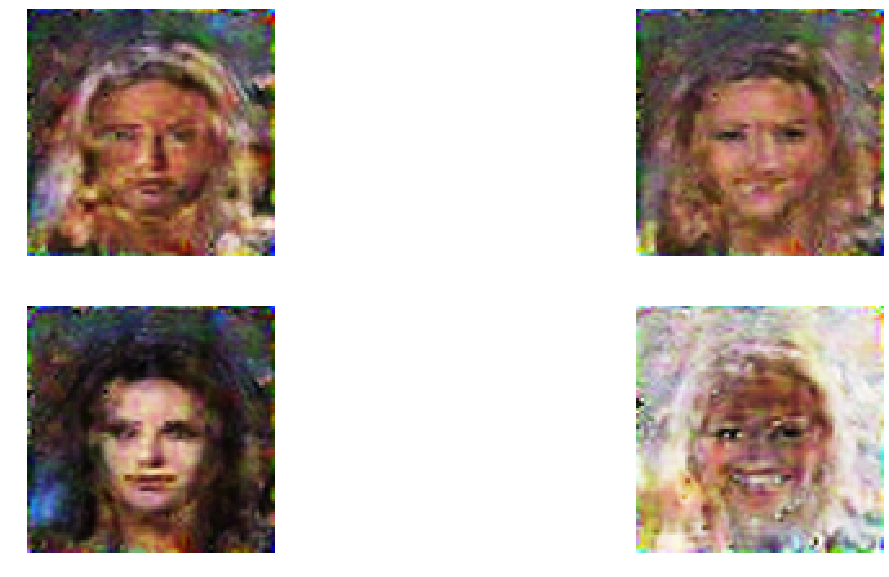

In [13]:
r, c =2,2
noise = np.random.normal(0, 1, (r * c, latent_dim))
gen_imgs = G.predict(noise)

fig, axs = plt.subplots(r, c, figsize=(20, 10))    
cnt = 0

for i in range(r):
    for j in range(c):
        img = gen_imgs[cnt, :,:,:]
        img = (0.5+img*0.5)
        img = img[...,::-1]
        img = (img*255).astype("uint8")
        img = cv2.resize(img,None,fx=2-resize_factor, fy=2-resize_factor, interpolation = cv2.INTER_CUBIC)
        axs[i,j].imshow(img)
        axs[i,j].axis('off')
        cnt += 1